# Zindi Project - Financial Inclusion in Africa

Financial inclusion remains one of the main obstacles to economic and human development in Africa. For example, across Kenya, Rwanda, Tanzania, and Uganda only 9.1 million adults (or 14% of adults) have access to or use a commercial bank account.

Traditionally, access to bank accounts has been regarded as an indicator of financial inclusion. Despite the proliferation of mobile money in Africa, and the growth of innovative fintech solutions, banks still play a pivotal role in facilitating access to financial services. Access to bank accounts enable households to save and make payments while also helping businesses build up their credit-worthiness and improve their access to loans, insurance, and related services. Therefore, access to bank accounts is an essential contributor to long-term economic growth.

__The objective of this project is to create a machine learning model to predict which individuals are most likely to have or use a bank account.__ The models and solutions developed can provide an indication of the state of financial inclusion in Kenya, Rwanda, Tanzania and Uganda, while providing insights into some of the key factors driving individuals’ financial security.

# Our Goal

Our Goal is to predict values for our NaNs in our target column bank_account. 

## Data Overview

| column | additional information |
|--------|------------------------|
| country | Country interviewee is in |
| year | Year survey was done in  |
| uniqueid | Unique identifier for each interviewee | 
| location_type | Type of location: Rural, Urban |
| cellphone_access | If interviewee has access to a cellphone: Yes, No |
| household_size | Number of people living in one house |
| age_of_respondent | The age of the interviewee |
| gender_of_respondent | Gender of interviewee: Male, Female | 
| relationship_with_head | The interviewee’s relationship with the head of the house:Head of Household, Spouse, Child, Parent, Other relative, Other non-relatives, Dont know |
| marital_status | The martial status of the interviewee: Married/Living together, Divorced/Seperated, Widowed, Single/Never Married, Don’t know |
| education_level | Highest level of education: No formal education, Primary education, Secondary education, Vocational/Specialised training, Tertiary education, Other/Dont know/RTA |
| job_type | Type of job interviewee has: Farming and Fishing, Self employed, Formally employed Government, Formally employed Private, Informally employed, Remittance Dependent, Government Dependent, Other Income, No Income, Dont Know/Refuse to answer |

Importing Modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from scipy.stats import chi2_contingency
from matplotlib.ticker import PercentFormatter
from sklearn.model_selection import train_test_split, GridSearchCV
import imblearn
plt.rcParams["patch.force_edgecolor"] = True
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from scipy import stats

Importing the data

In [2]:
# Import the data into a dataframe
test = pd.read_csv('data/Test.csv')
train = pd.read_csv('data/train.csv')

# Make a new Dataframe with all the data
df = pd.concat([test, train])

In [3]:
# Export the dataframe into a csv:

# Define the path to the folder in your repository
folder_path = 'data/'

# Define the file name and extension
file_name = 'data.csv'

# Concatenate the folder path and file name
file_path = f'{folder_path}/{file_name}'

# Export the DataFrame to the specified folder
df.to_csv(file_path, index=False)


## EDA: Exploring the data

In this part of the notebook we look and analyze our financial inclusion data we got from Zindi.

In [4]:
# Print the shape of the data
print('Financial Inclusion dataset')
print('==================')
print('# observations: {}'.format(df.shape[0]))
print('# features:     {}'.format(df.shape[1]-1))

Financial Inclusion dataset
# observations: 33610
# features:     12


In [5]:
# Display first 5 rows
df.head()

,country,year,uniqueid,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type,bank_account
0,Kenya,2018,uniqueid_6056,Urban,Yes,3,30,Male,Head of Household,Married/Living together,Secondary education,Formally employed Government,NaN
1,Kenya,2018,uniqueid_6060,Urban,Yes,7,51,Male,Head of Household,Married/Living together,Vocational/Specialised training,Formally employed Private,NaN
2,Kenya,2018,uniqueid_6065,Rural,No,3,77,Female,Parent,Married/Living together,No formal education,Remittance Dependent,NaN
3,Kenya,2018,uniqueid_6072,Rural,No,6,39,Female,Head of Household,Married/Living together,Primary education,Remittance Dependent,NaN
4,Kenya,2018,uniqueid_6073,Urban,No,3,16,Male,Child,Single/Never Married,Secondary education,Remittance Dependent,NaN


In [6]:
# Print a concise summary of a DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33610 entries, 0 to 23523
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   country                 33610 non-null  object
 1   year                    33610 non-null  int64 
 2   uniqueid                33610 non-null  object
 3   location_type           33610 non-null  object
 4   cellphone_access        33610 non-null  object
 5   household_size          33610 non-null  int64 
 6   age_of_respondent       33610 non-null  int64 
 7   gender_of_respondent    33610 non-null  object
 8   relationship_with_head  33610 non-null  object
 9   marital_status          33610 non-null  object
 10  education_level         33610 non-null  object
 11  job_type                33610 non-null  object
 12  bank_account            23524 non-null  object
dtypes: int64(3), object(10)
memory usage: 3.6+ MB


In [7]:
# Generate descriptive statistics
df.describe()

,year,household_size,age_of_respondent
count,33610.000000,33610.000000,33610.000000
mean,2016.975930,3.791877,38.656114
std,0.847353,2.223138,16.447127
min,2016.000000,1.000000,16.000000
25%,2016.000000,2.000000,26.000000
50%,2017.000000,3.000000,35.000000
75%,2018.000000,5.000000,49.000000
max,2018.000000,21.000000,100.000000


In [8]:
# The column labels of the DataFrame.
df.columns

Index(['country', 'year', 'uniqueid', 'location_type', 'cellphone_access',
       'household_size', 'age_of_respondent', 'gender_of_respondent',
       'relationship_with_head', 'marital_status', 'education_level',
       'job_type', 'bank_account'],
      dtype='object')

In [9]:
# Check for missing values
df.isnull().sum()

country                       0
year                          0
uniqueid                      0
location_type                 0
cellphone_access              0
household_size                0
age_of_respondent             0
gender_of_respondent          0
relationship_with_head        0
marital_status                0
education_level               0
job_type                      0
bank_account              10086
dtype: int64

In [10]:
# check for unique values in column bank_account
df['bank_account'].unique()

array([nan, 'Yes', 'No'], dtype=object)

In [11]:
# Checking for data imbalance
df['bank_account'].value_counts()

bank_account
No     20212
Yes     3312
Name: count, dtype: int64

We see that we have NaNs in the column bank account. Our goal is to fill this Nan values with values that our model (hopefully) predicts right.

What we need to do is:
* Create a data frame without NaNs. This will be the data we than will split into train and test data.
* Create a data frame with all the NaN values. This will be the data we than will have our model predict with.

In [12]:
# Create a new data frame without the NaN in our target feature
df_wo_target_nan = df.dropna()

# set new index for our dataframe without the NaNs
df_wo_target_nan = df_wo_target_nan.reset_index(drop=True)
df_wo_target_nan.isnull().value_counts()
df_wo_target_nan.head()

,country,year,uniqueid,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type,bank_account
0,Kenya,2018,uniqueid_1,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed,Yes
1,Kenya,2018,uniqueid_2,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent,No
2,Kenya,2018,uniqueid_3,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed,Yes
3,Kenya,2018,uniqueid_4,Rural,Yes,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private,No
4,Kenya,2018,uniqueid_5,Urban,No,8,26,Male,Child,Single/Never Married,Primary education,Informally employed,No


In [13]:
# create a new data frame with only the NaN in our target feature
df_with_target_nan = df.where(df['bank_account'].isnull())
df_with_target_nan.head()

# Set a new index for our dataframe with the NaNs
df_with_target_nan = df_with_target_nan.reset_index(drop=True)
df_with_target_nan.head()

,country,year,uniqueid,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type,bank_account
0,Kenya,2018.0,uniqueid_6056,Urban,Yes,3.0,30.0,Male,Head of Household,Married/Living together,Secondary education,Formally employed Government,NaN
1,Kenya,2018.0,uniqueid_6060,Urban,Yes,7.0,51.0,Male,Head of Household,Married/Living together,Vocational/Specialised training,Formally employed Private,NaN
2,Kenya,2018.0,uniqueid_6065,Rural,No,3.0,77.0,Female,Parent,Married/Living together,No formal education,Remittance Dependent,NaN
3,Kenya,2018.0,uniqueid_6072,Rural,No,6.0,39.0,Female,Head of Household,Married/Living together,Primary education,Remittance Dependent,NaN
4,Kenya,2018.0,uniqueid_6073,Urban,No,3.0,16.0,Male,Child,Single/Never Married,Secondary education,Remittance Dependent,NaN


At this point we now focus on our dataframe without the NaNs. 
Quick look at the dataframe:

In [14]:
df_wo_target_nan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23524 entries, 0 to 23523
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   country                 23524 non-null  object
 1   year                    23524 non-null  int64 
 2   uniqueid                23524 non-null  object
 3   location_type           23524 non-null  object
 4   cellphone_access        23524 non-null  object
 5   household_size          23524 non-null  int64 
 6   age_of_respondent       23524 non-null  int64 
 7   gender_of_respondent    23524 non-null  object
 8   relationship_with_head  23524 non-null  object
 9   marital_status          23524 non-null  object
 10  education_level         23524 non-null  object
 11  job_type                23524 non-null  object
 12  bank_account            23524 non-null  object
dtypes: int64(3), object(10)
memory usage: 2.3+ MB


In [15]:
df_wo_target_nan.describe()

,year,household_size,age_of_respondent
count,23524.000000,23524.000000,23524.000000
mean,2016.975939,3.797483,38.805220
std,0.847371,2.227613,16.520569
min,2016.000000,1.000000,16.000000
25%,2016.000000,2.000000,26.000000
50%,2017.000000,3.000000,35.000000
75%,2018.000000,5.000000,49.000000
max,2018.000000,21.000000,100.000000


In [16]:
df_wo_target_nan.head().T

,0,1,2,3,4
country,Kenya,Kenya,Kenya,Kenya,Kenya
year,2018,2018,2018,2018,2018
uniqueid,uniqueid_1,uniqueid_2,uniqueid_3,uniqueid_4,uniqueid_5
location_type,Rural,Rural,Urban,Rural,Urban
cellphone_access,Yes,No,Yes,Yes,No
household_size,3,5,5,5,8
age_of_respondent,24,70,26,34,26
gender_of_respondent,Female,Female,Male,Female,Male
relationship_with_head,Spouse,Head of Household,Other relative,Head of Household,Child
marital_status,Married/Living together,Widowed,Single/Never Married,Married/Living together,Single/Never Married


In [17]:
# Show overview of all the unique values of the dataframe:
for column in df_wo_target_nan.columns:
    unique_values = df_wo_target_nan[column].unique()
    print(f"Column '{column}' has {len(unique_values)} unique value(s):")
    print(unique_values)
    print()

Column 'country' has 4 unique value(s):
['Kenya' 'Rwanda' 'Tanzania' 'Uganda']

Column 'year' has 3 unique value(s):
[2018 2016 2017]

Column 'uniqueid' has 8735 unique value(s):
['uniqueid_1' 'uniqueid_2' 'uniqueid_3' ... 'uniqueid_8757'
 'uniqueid_8758' 'uniqueid_8759']

Column 'location_type' has 2 unique value(s):
['Rural' 'Urban']

Column 'cellphone_access' has 2 unique value(s):
['Yes' 'No']

Column 'household_size' has 20 unique value(s):
[ 3  5  8  7  1  6  4 10  2 11  9 12 16 15 13 14 21 18 17 20]

Column 'age_of_respondent' has 85 unique value(s):
[ 24  70  26  34  32  42  54  76  40  69  64  31  38  47  27  48  25  21
  18  22  58  55  62  29  35  45  67  19  80  66  50  33  28  51  16  17
  30  37  59  65  46  56  52  23  43  49  44  72  53  63  39  81  78  36
  20  60  95  71  57  85  68  41  61  75  86  73  93  74  88  90  77  84
  82  89  79  83  94  87  92  91  98  97  96  99 100]

Column 'gender_of_respondent' has 2 unique value(s):
['Female' 'Male']

Column 'relations

In [18]:
# Checking for duplicate values
print(f"duplicate values in columns")

display(df_wo_target_nan.duplicated().value_counts())

print('No duplicates found.')
print("______"*30)

duplicate values in columns


False    23524
Name: count, dtype: int64

No duplicates found.
____________________________________________________________________________________________________________________________________________________________________________________


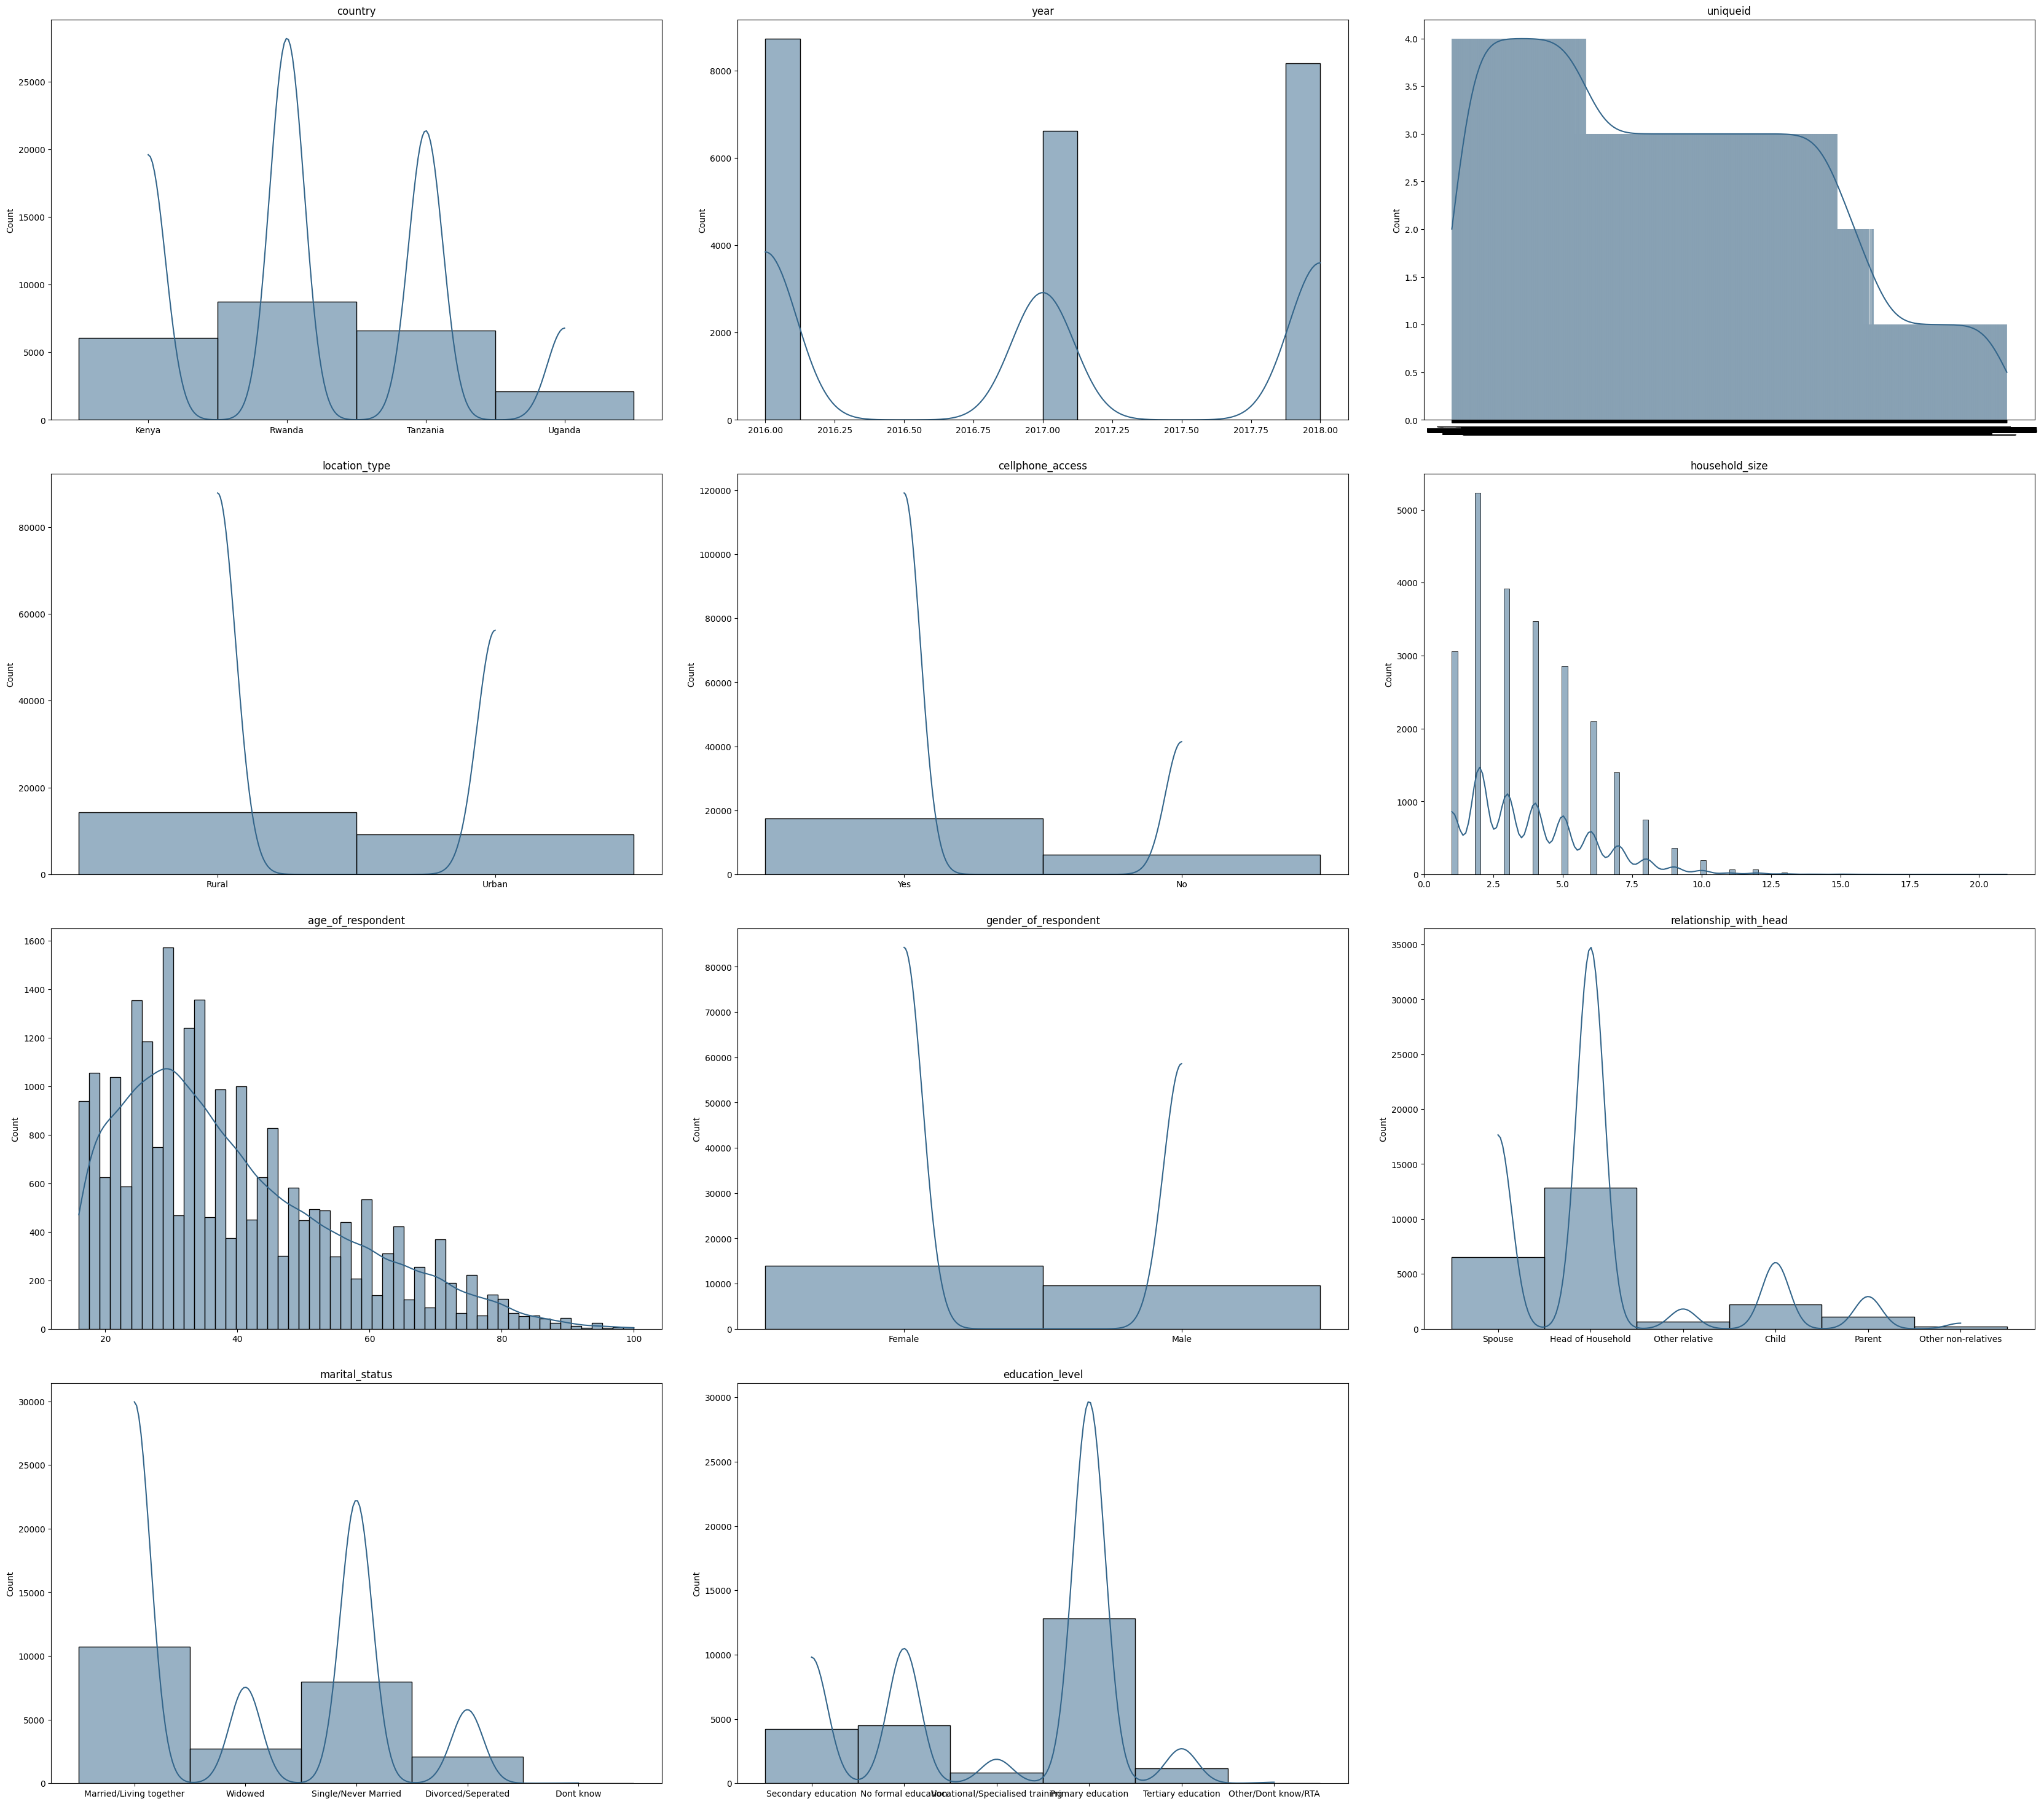

In [19]:
# Plot distribution of features 

features = df_wo_target_nan.columns.tolist()
features.remove('bank_account')

fig,ax = plt.subplots(4,3,figsize=(34,30))
count = 0
for item in features:
    sns.histplot(df_wo_target_nan[item], kde=True, ax=ax[int(count/3)][count%3], color='#33658A').set(title=item, xlabel='')
    count += 1
ax.flat[-1].set_visible(False)
fig.tight_layout(pad=3);

In [20]:
# Plotting correlation between numeric columns
numeric_df = df_wo_target_nan.select_dtypes(include='number')
correlation_matrix = numeric_df.corr()

fig = go.Figure(data=go.Heatmap(z=correlation_matrix.values, x=correlation_matrix.columns, y=correlation_matrix.index))

fig.show()

In [21]:
# Initialize an empty matrix to store Cramér's V 
'''
n_columns = len(df_wo_target_nan.columns)
cramers_matrix = np.zeros((n_columns, n_columns))

# Iterate over each pair of columns
for i in range(n_columns):
    for j in range(n_columns):
        # Create a contingency table for the column pair
        contingency_table = pd.crosstab(df_wo_target_nan.iloc[:, i], df.iloc[:, j])
        
        # Perform the chi-square test and calculate Cramér's V
        chi2, _, _, _ = chi2_contingency(contingency_table)
        n = len(df_wo_target_nan)
        cramers_v = np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))
        
        # Store the Cramér's V value in the matrix
        cramers_matrix[i, j] = cramers_v

# Create a DataFrame from the matrix with column names as indices and columns
cramers_df = pd.DataFrame(cramers_matrix, index=df_wo_target_nan.columns, columns=df_wo_target_nan.columns)

# Create a heatmap using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cramers_df, annot=True, fmt=".2f", cmap="crest", square=True)
plt.title("Cramér's V Heatmap")
plt.show()
'''

'\nn_columns = len(df_wo_target_nan.columns)\ncramers_matrix = np.zeros((n_columns, n_columns))\n\n# Iterate over each pair of columns\nfor i in range(n_columns):\n    for j in range(n_columns):\n        # Create a contingency table for the column pair\n        contingency_table = pd.crosstab(df_wo_target_nan.iloc[:, i], df.iloc[:, j])\n        \n        # Perform the chi-square test and calculate Cramér\'s V\n        chi2, _, _, _ = chi2_contingency(contingency_table)\n        n = len(df_wo_target_nan)\n        cramers_v = np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))\n        \n        # Store the Cramér\'s V value in the matrix\n        cramers_matrix[i, j] = cramers_v\n\n# Create a DataFrame from the matrix with column names as indices and columns\ncramers_df = pd.DataFrame(cramers_matrix, index=df_wo_target_nan.columns, columns=df_wo_target_nan.columns)\n\n# Create a heatmap using Seaborn\nplt.figure(figsize=(10, 8))\nsns.heatmap(cramers_df, annot=True, fmt=".2f", cmap=

In [22]:
# descriptive statistics for specific columns with numerical features
num_cols = ["age_of_respondent", "household_size", "year"]
# check table again
num_data = df_wo_target_nan[num_cols]
print("______"*30)
display(num_data.head(10))
print("______"*30)
display(num_data.describe())
print("______"*30)

____________________________________________________________________________________________________________________________________________________________________________________


,age_of_respondent,household_size,year
0,24,3,2018
1,70,5,2018
2,26,5,2018
3,34,5,2018
4,26,8,2018
5,26,7,2018
6,32,7,2018
7,42,1,2018
8,54,3,2018
9,76,3,2018


____________________________________________________________________________________________________________________________________________________________________________________


,age_of_respondent,household_size,year
count,23524.000000,23524.000000,23524.000000
mean,38.805220,3.797483,2016.975939
std,16.520569,2.227613,0.847371
min,16.000000,1.000000,2016.000000
25%,26.000000,2.000000,2016.000000
50%,35.000000,3.000000,2017.000000
75%,49.000000,5.000000,2018.000000
max,100.000000,21.000000,2018.000000


____________________________________________________________________________________________________________________________________________________________________________________


75% of the respondents have 49 years old. This could be explained by the fact that the average life expectancy in Africa is still very low compared to other continents. Concerning this column, there is also a big difference comparing with the maximum value of 100. There are some ouliers in these column, that must be analysed before modelling.
<br>

We can also predict outliers in the column ‘household_size’ due to the huge difference between the 75% of the respondents having 5 people living in their houses, and a maximum value of 21 people.

In [23]:
df = px.data.tips()
fig = px.box(df_wo_target_nan, y='age_of_respondent')
fig.show()

In [24]:
df = px.data.tips()
fig = px.box(df_wo_target_nan, y='household_size')
fig.show()

Find out if there is a relation between the features (which contains objects) and our target feature, using the "Cramers V".

* Small Effect:
Cramér's V values close to 0 indicate a weak or negligible association between the categorical variables.

* Medium Effect:
Cramér's V values around 0.1 to 0.3 suggest a moderate association. This indicates that the variables have some degree of dependency, but the association may not be very strong.

* Large Effect:
Cramér's V values close to 0.3 or higher indicate a relatively strong association between the categorical variables. This suggests a notable dependency or relationship between the variables.


In [25]:
# Check each column vs. the target column if there is a correlation by creating a function using the Cramér's V:

# make a list with each column name 
column_names = df_wo_target_nan.columns.tolist()
# delete bank_account from the list
column_names.remove('bank_account')
# create target value
target_column = 'bank_account'

def cramers_v(list, target_column):
    
    for name in list:
        # Create a contingency table
        contingency_table = pd.crosstab(df_wo_target_nan[name], df_wo_target_nan[target_column])

        # Perform chi-square test
        chi2, p, *_ = chi2_contingency(contingency_table)

        # Calculate Cramér's V
        n = len(df_wo_target_nan)
        cramers_v = np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))

        # only print output is cramers_v is bigger than 0.1
        if cramers_v >= 0.1:

            print('-----------------------------')
            print(f'{name} vs. {target_column}')
            # print("Chi-square:", chi2)
            # print("p-value:", p)
            print("Cramér's V:", round(cramers_v, 3))
        

cramers_v(column_names, target_column)
cramers_v(['job_type'], 'education_level')

-----------------------------
country vs. bank_account
Cramér's V: 0.189
-----------------------------
year vs. bank_account
Cramér's V: 0.144
-----------------------------
uniqueid vs. bank_account
Cramér's V: 0.595
-----------------------------
cellphone_access vs. bank_account
Cramér's V: 0.21
-----------------------------
age_of_respondent vs. bank_account
Cramér's V: 0.14
-----------------------------
gender_of_respondent vs. bank_account
Cramér's V: 0.117
-----------------------------
relationship_with_head vs. bank_account
Cramér's V: 0.118
-----------------------------
education_level vs. bank_account
Cramér's V: 0.388
-----------------------------
job_type vs. bank_account
Cramér's V: 0.359
-----------------------------
job_type vs. education_level
Cramér's V: 0.192


Because there is a medium correlation between job type and education level and a high correlation between job type/bank account and education level/bank account: let's make a plot to show it.


In [26]:
# Check each column vs. the target column if there is a correlation by creating a function using the Cramér's V:

# make a list with each column name 
column_names = df_wo_target_nan.columns.tolist()
# delete bank_account from the list
column_names.remove('bank_account')
column_names.remove('uniqueid')
# create target value
target_names = column_names

def cramers_v(list_columns, list_targets):
    
    for name in list_columns:
        # Create a contingency 
        for target in list_targets:
            if name != target:
                contingency_table = pd.crosstab(df_wo_target_nan[name], df_wo_target_nan[target])

                # Perform chi-square test
                chi2, p, *_ = chi2_contingency(contingency_table)

                # Calculate Cramér's V
                n = len(df_wo_target_nan)
                cramers_v = np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))

                # only print output is cramers_v is bigger than 0.1
                if cramers_v >= 0.3:

                    print('-----------------------------')
                    print(f'{name} vs. {target}')
                    # print("Chi-square:", chi2)
                    # print("p-value:", p)
                    print("Cramér's V:", round(cramers_v, 3))
            

cramers_v(column_names, target_names)
# cramers_v(['job_type'], 'education_level')

-----------------------------
country vs. year
Cramér's V: 1.0
-----------------------------
country vs. location_type
Cramér's V: 0.484
-----------------------------
country vs. household_size
Cramér's V: 0.315
-----------------------------
country vs. job_type
Cramér's V: 0.452
-----------------------------
year vs. country
Cramér's V: 1.0
-----------------------------
year vs. location_type
Cramér's V: 0.479
-----------------------------
year vs. household_size
Cramér's V: 0.369
-----------------------------
year vs. marital_status
Cramér's V: 0.347
-----------------------------
year vs. job_type
Cramér's V: 0.435
-----------------------------
location_type vs. country
Cramér's V: 0.484
-----------------------------
location_type vs. year
Cramér's V: 0.479
-----------------------------
location_type vs. job_type
Cramér's V: 0.415
-----------------------------
household_size vs. country
Cramér's V: 0.315
-----------------------------
household_size vs. year
Cramér's V: 0.369
--------

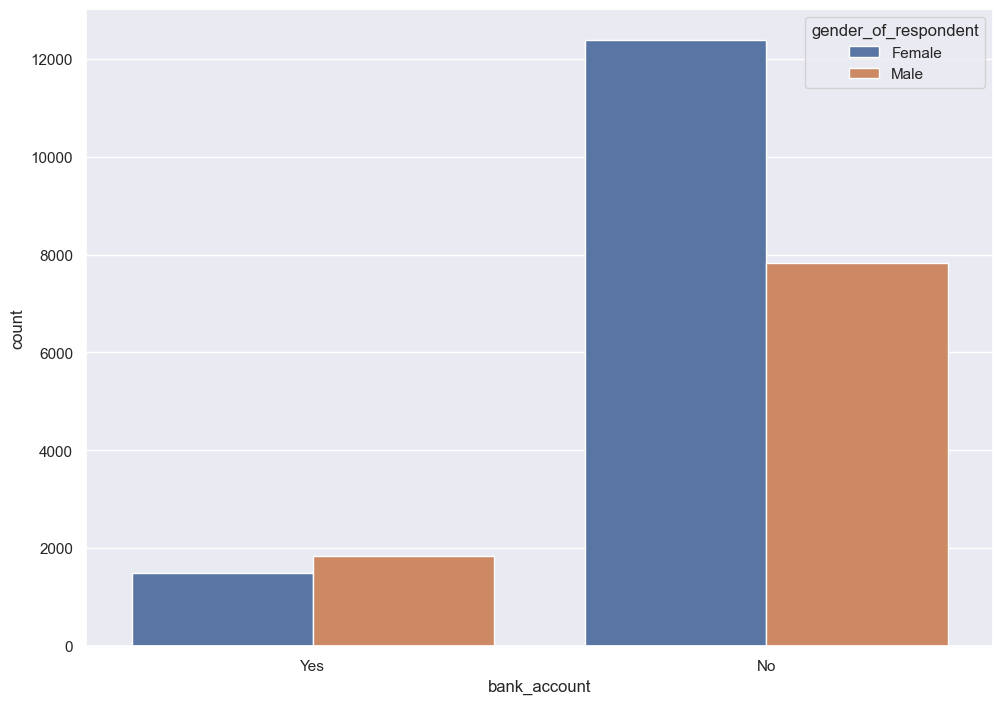

In [27]:
# Countplot with bank account, hue=gender
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.countplot(x=df_wo_target_nan['bank_account'], hue=df_wo_target_nan['gender_of_respondent']);

## Cleaning the data

We now drop columns if they:

* are an ID
* have no to negligible correlation to the target feature


In [28]:
df_wo_target_nan.columns

Index(['country', 'year', 'uniqueid', 'location_type', 'cellphone_access',
       'household_size', 'age_of_respondent', 'gender_of_respondent',
       'relationship_with_head', 'marital_status', 'education_level',
       'job_type', 'bank_account'],
      dtype='object')

Renaming the columns for better readability:

In [29]:
# Renaming the column names
df_wo_target_nan.rename(columns = {'country': 'country',
        'year': 'year',
        'uniqueid': 'id',
        'location_type': 'location',
        'cellphone_access': 'cellphone',
        'household_size': 'household_size',
        'age_of_respondent': 'age',
        'gender_of_respondent': 'gender',
        'relationship_with_head': 'relationship_with_head', 
        'marital_status': 'marital_status', 
        'education_level': 'education',
        'job_type': 'job',
        'bank_account': 'bank_account'},
        inplace = True)

df_wo_target_nan.head().T

,0,1,2,3,4
country,Kenya,Kenya,Kenya,Kenya,Kenya
year,2018,2018,2018,2018,2018
id,uniqueid_1,uniqueid_2,uniqueid_3,uniqueid_4,uniqueid_5
location,Rural,Rural,Urban,Rural,Urban
cellphone,Yes,No,Yes,Yes,No
household_size,3,5,5,5,8
age,24,70,26,34,26
gender,Female,Female,Male,Female,Male
relationship_with_head,Spouse,Head of Household,Other relative,Head of Household,Child
marital_status,Married/Living together,Widowed,Single/Never Married,Married/Living together,Single/Never Married


In [30]:
# drop id column
df_wo_target_nan = df_wo_target_nan.drop('id', axis=1)
df_wo_target_nan.head().T

,0,1,2,3,4
country,Kenya,Kenya,Kenya,Kenya,Kenya
year,2018,2018,2018,2018,2018
location,Rural,Rural,Urban,Rural,Urban
cellphone,Yes,No,Yes,Yes,No
household_size,3,5,5,5,8
age,24,70,26,34,26
gender,Female,Female,Male,Female,Male
relationship_with_head,Spouse,Head of Household,Other relative,Head of Household,Child
marital_status,Married/Living together,Widowed,Single/Never Married,Married/Living together,Single/Never Married
education,Secondary education,No formal education,Vocational/Specialised training,Primary education,Primary education


In [31]:
df_wo_target_nan.nunique()

country                    4
year                       3
location                   2
cellphone                  2
household_size            20
age                       85
gender                     2
relationship_with_head     6
marital_status             5
education                  6
job                       10
bank_account               2
dtype: int64

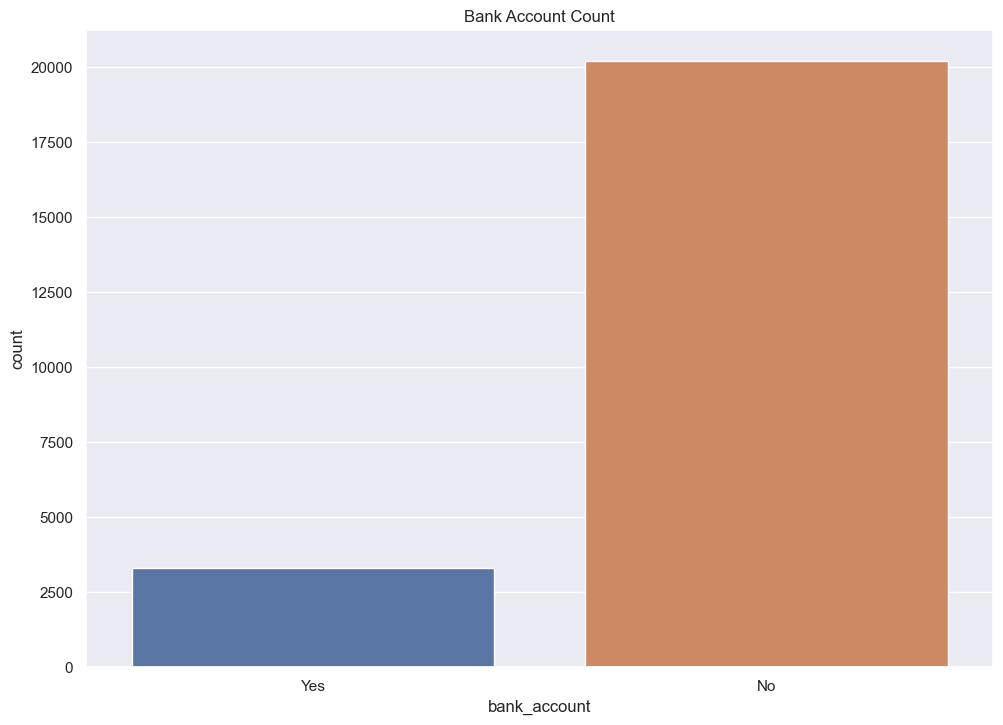

In [32]:
# Plotting the target variable
plt.title('Bank Account Count')
sns.countplot(x=df_wo_target_nan.bank_account);

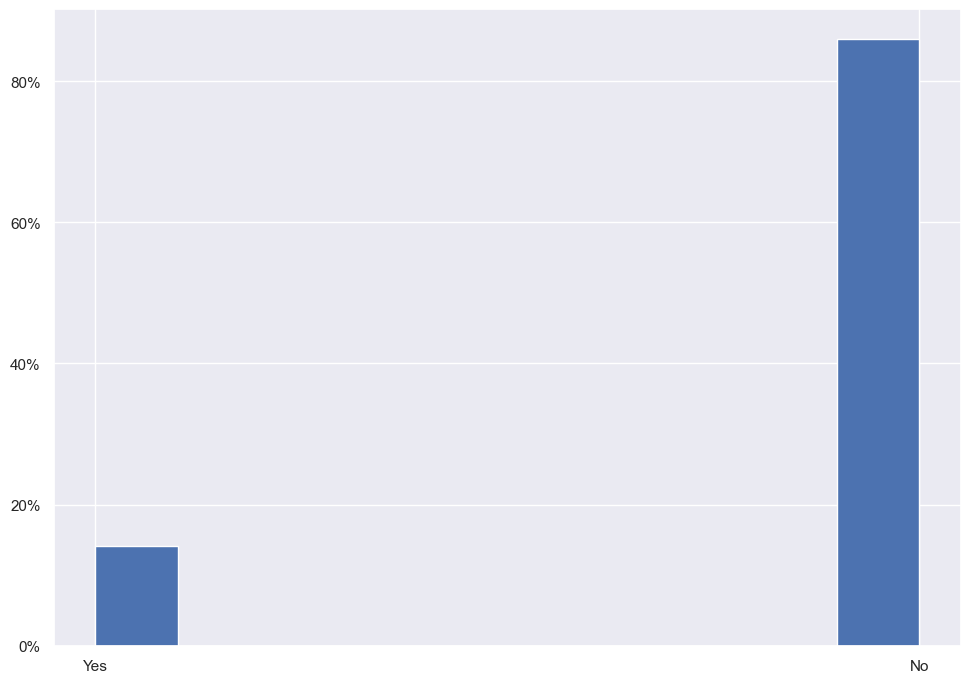

In [33]:
# plot which shows percentage of people with and without a bank account
data = df_wo_target_nan['bank_account']

plt.hist(data, weights=np.ones(len(data)) / len(data))

plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

In [34]:
df_wo_target_nan['bank_account'].value_counts()

bank_account
No     20212
Yes     3312
Name: count, dtype: int64

In the two histogramm plots we can see that the data isn't well balanced. Out of 23.524 people in our dataset only 3.312 people (~18%) have a bank account. 20.212 don't.

&rarr; We need to remove our majority class!
<br>

In this plot we can see that we have outliers in the household_size column and also in the age column.

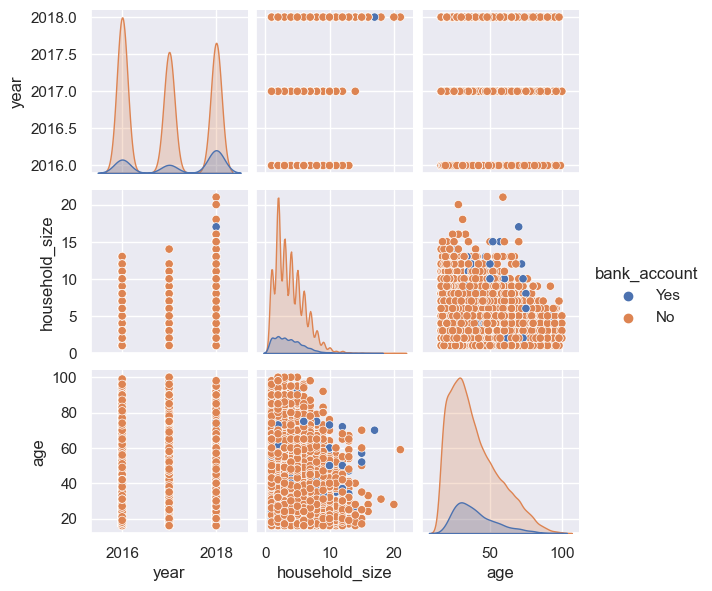

In [35]:
# Plotting a pairplot to see how the variables differ depending on our target variable - 'bank_account'
sns.pairplot(df_wo_target_nan, hue='bank_account', height=2);

---

<br>

We have many categorical values and a few discreet values:
* create dummy variables (hot-one encoding for categorical values)
* bin discreet values (discreet values)
* create a csv file with the results


In [36]:
df_final = pd.read_csv('data/data_binary.csv')

In [37]:
# make values astyp int to properly use the RandomOverSampler
df_final = df_final.astype(int)

In [38]:
df_final.head()

,household_size_1-2,household_size_2-5,household_size_5-10,household_size_10-25,age_0-20,age_20-40,age_40-70,age_70-100,country_Rwanda,country_Tanzania,...,job_Farming and Fishing,job_Formally employed Government,job_Formally employed Private,job_Government Dependent,job_Informally employed,job_No Income,job_Other Income,job_Remittance Dependent,job_Self employed,bank_account_Yes
0,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
1,0,0,1,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
3,0,0,1,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


Because our target feature is unbalanced: we have an overfitting in our target category &rarr; no is the majority class 

In [39]:
# TRAIN TEST SPLIT  
# Defining X and y
features = df_final.columns.tolist()
features.remove('bank_account_Yes')
# Target
# y = heart.heart_attack
# Predictors
# X = heart.drop('heart_attack', axis=1) instead of making a list of features in line 2 and 3. So you don't have to drop the column in the dataframe

X = df_final[features]
y = df_final.bank_account_Yes

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True, stratify=y)

# Check the shape of the data sets
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

X_train: (16466, 39)
y_train: (16466,)
X_test: (7058, 39)
y_test: (7058,)


Use oversampling to balance out the minority class

In [40]:
# Oversampling
oversample = imblearn.over_sampling.RandomOverSampler(sampling_strategy='minority')

X_train_over, y_train_over = oversample.fit_resample(X_train, y_train)

display('X_train: ' + str(X_train.shape))
display('y_train: ' + str(y_train.shape))
display('X_train_over: ' + str(X_train_over.shape))
display('y_train_over: ' + str(y_train_over.shape))

count_yes, count_no = 0, 0
for i in y_train_over:
    if i == 1:
        count_yes += 1
    if i == 0:
        count_no += 1
print (count_yes, count_no)


'X_train: (16466, 39)'

'y_train: (16466,)'

'X_train_over: (28296, 39)'

'y_train_over: (28296,)'

14148 14148


# Modeling

## Decision Tree

In [41]:
dtree = DecisionTreeClassifier()
dtree.fit(X_train_over, y_train_over)

DecisionTreeClassifier()

In [42]:
# Your code here!
y_pred_tree = dtree.predict(X_test)
print(confusion_matrix(y_test, y_pred_tree))
print(classification_report(y_test, y_pred_tree))

[[4986 1078]
 [ 369  625]]
              precision    recall  f1-score   support

           0       0.93      0.82      0.87      6064
           1       0.37      0.63      0.46       994

    accuracy                           0.79      7058
   macro avg       0.65      0.73      0.67      7058
weighted avg       0.85      0.79      0.82      7058



## Logistic Regression

In [43]:
# Logistic Regression (base?) - line model:
#df = pd.read_csv('data/data.csv')
# create a new data frame without the NaN in our target feature
#df_wo_target_nan = df.dropna(axis=0)
# Defining X and y
#features = df_wo_target_nan.columns.tolist()
#features.remove('bank_account')
#X = df_wo_target_nan[features]
#y = df_wo_target_nan.bank_account
# Splitting the dataset
#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=True)
#Oversampling
#oversample = imblearn.over_sampling.RandomOverSampler(sampling_strategy='minority')
#X_train_over, y_train_over = oversample.fit_resample(X_train, y_train)
# Encode categorical features
enc = preprocessing.OrdinalEncoder()
X_train_fitted_transformed = enc.fit_transform(X_train_over)
X_test_fitted_transformed = enc.fit_transform(X_test)
### Using Logistic regression using non-scaled data
log_reg = LogisticRegression(max_iter=10000)
log_reg.fit(X_train_fitted_transformed, y_train_over)
y_pred_train = log_reg.predict(X_train_fitted_transformed)
y_pred = log_reg.predict(X_test_fitted_transformed)
# Print accuracy of our model
print("Accuracy on train set:", round(accuracy_score(y_train_over, y_pred_train), 2))
print("Accuracy on test set:", round(accuracy_score(y_test, y_pred), 2))
print("--------"*10)
# Print MAE of our model
y_pred_train_ = []
y_pred_ = []
for i in y_pred_train:
    if i == 1: y_pred_train_.append(1)
    if i == 0: y_pred_train_.append(0)
for i in y_pred:
    if i == 1: y_pred_.append(1)
    if i == 0: y_pred_.append(0)
print("Mean absolute error on train set:", round(mean_absolute_error(y_train_over, y_pred_train_),2))
print("Mean absolute error on test set:", round(mean_absolute_error(y_test, y_pred_),2))
print("--------"*10)

Accuracy on train set: 0.77
Accuracy on test set: 0.79
--------------------------------------------------------------------------------
Mean absolute error on train set: 0.23
Mean absolute error on test set: 0.21
--------------------------------------------------------------------------------


## Random Forest Model

In [44]:
# initializing the model and fitting it
forest = RandomForestClassifier()
forest.fit(X_train_over, y_train_over)

RandomForestClassifier()

In [45]:
# Evaluating the model
y_pred_forest = forest.predict(X_test)
print(confusion_matrix(y_test, y_pred_forest))
print(classification_report(y_test, y_pred_forest))

[[5022 1042]
 [ 357  637]]
              precision    recall  f1-score   support

           0       0.93      0.83      0.88      6064
           1       0.38      0.64      0.48       994

    accuracy                           0.80      7058
   macro avg       0.66      0.73      0.68      7058
weighted avg       0.86      0.80      0.82      7058



In [46]:
RSEED = 50
# Hyperparameter grid
param_grid = {
    'n_estimators': np.linspace(10, 200).astype(int),
    'max_depth': [None] + list(np.linspace(3, 20).astype(int)),
    'max_features': ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1)),
    'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
}

# Estimator for use in random search
estimator = RandomForestClassifier(random_state = RSEED)
# pimp the scoring for rs
from sklearn.metrics import fbeta_score, make_scorer
scorer = make_scorer(fbeta_score, beta=2)
# Create the random search model
rs = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
                        scoring = scorer, cv = 3, 
                        n_iter = 10, verbose = 5, random_state=RSEED)

# Fit 
rs.fit(X_train_over, y_train_over)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/shahiwinderling/neuefische/Financial-Inclusion-Project/.venv/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/shahiwinderling/neuefische/Financial-Inclusion-Project/.venv/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/shahiwinderling/neuefische/Financial-Inclusion-Project/.venv/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated

[CV 3/3] END bootstrap=False, max_depth=10, max_features=auto, max_leaf_nodes=28, min_samples_split=10, n_estimators=87;, score=0.731 total time=   0.8s
[CV 1/3] END bootstrap=False, max_depth=10, max_features=auto, max_leaf_nodes=28, min_samples_split=10, n_estimators=87;, score=0.740 total time=   1.1s
[CV 2/3] END bootstrap=False, max_depth=10, max_features=auto, max_leaf_nodes=28, min_samples_split=10, n_estimators=87;, score=0.762 total time=   1.2s
[CV 1/3] END bootstrap=False, max_depth=7, max_features=0.7, max_leaf_nodes=26, min_samples_split=10, n_estimators=153;, score=0.785 total time=   5.5s
[CV 2/3] END bootstrap=False, max_depth=7, max_features=0.7, max_leaf_nodes=26, min_samples_split=10, n_estimators=153;, score=0.747 total time=   5.4s


/Users/shahiwinderling/neuefische/Financial-Inclusion-Project/.venv/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/3] END bootstrap=True, max_depth=16, max_features=auto, max_leaf_nodes=43, min_samples_split=5, n_estimators=29;, score=0.760 total time=   0.3s
[CV 3/3] END bootstrap=True, max_depth=12, max_features=0.7999999999999999, max_leaf_nodes=33, min_samples_split=2, n_estimators=188;, score=0.754 total time=   6.2s
[CV 1/3] END bootstrap=True, max_depth=12, max_features=0.7999999999999999, max_leaf_nodes=33, min_samples_split=2, n_estimators=188;, score=0.770 total time=   6.2s


/Users/shahiwinderling/neuefische/Financial-Inclusion-Project/.venv/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/shahiwinderling/neuefische/Financial-Inclusion-Project/.venv/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/shahiwinderling/neuefische/Financial-Inclusion-Project/.venv/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated

[CV 3/3] END bootstrap=False, max_depth=7, max_features=0.7, max_leaf_nodes=26, min_samples_split=10, n_estimators=153;, score=0.743 total time=   5.5s
[CV 2/3] END bootstrap=True, max_depth=12, max_features=0.7999999999999999, max_leaf_nodes=33, min_samples_split=2, n_estimators=188;, score=0.766 total time=   6.4s
[CV 2/3] END bootstrap=True, max_depth=16, max_features=auto, max_leaf_nodes=43, min_samples_split=5, n_estimators=29;, score=0.766 total time=   0.3s
[CV 1/3] END bootstrap=True, max_depth=4, max_features=auto, max_leaf_nodes=17, min_samples_split=5, n_estimators=25;, score=0.724 total time=   0.2s


/Users/shahiwinderling/neuefische/Financial-Inclusion-Project/.venv/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/shahiwinderling/neuefische/Financial-Inclusion-Project/.venv/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/3] END bootstrap=True, max_depth=4, max_features=auto, max_leaf_nodes=17, min_samples_split=5, n_estimators=25;, score=0.741 total time=   0.2s
[CV 3/3] END bootstrap=True, max_depth=16, max_features=auto, max_leaf_nodes=43, min_samples_split=5, n_estimators=29;, score=0.746 total time=   0.3s
[CV 3/3] END bootstrap=True, max_depth=4, max_features=auto, max_leaf_nodes=17, min_samples_split=5, n_estimators=25;, score=0.712 total time=   0.2s
[CV 1/3] END bootstrap=True, max_depth=16, max_features=0.7999999999999999, max_leaf_nodes=11, min_samples_split=5, n_estimators=25;, score=0.709 total time=   0.6s
[CV 2/3] END bootstrap=True, max_depth=16, max_features=0.7999999999999999, max_leaf_nodes=11, min_samples_split=5, n_estimators=25;, score=0.692 total time=   0.6s
[CV 3/3] END bootstrap=True, max_depth=16, max_features=0.7999999999999999, max_leaf_nodes=11, min_samples_split=5, n_estimators=25;, score=0.668 total time=   0.6s
[CV 1/3] END bootstrap=True, max_depth=8, max_features

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=50),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 3, 3, 3, 4, 4, 4, 5,
                                                      5, 5, 6, 6, 6, 7, 7, 7, 8,
                                                      8, 8, 9, 9, 9, 10, 10, 10,
                                                      11, 11, 12, 12, 12, ...],
                                        'max_features': ['auto', 'sqrt', None,
                                                         0.5, 0.6, 0.7,
                                                         0.7999999999999999,
                                                         0.8999999999999999],
                                        'max_leaf_nodes': [None, 10, 10, 10, 10,
                                                           10, 10, 10, 1...
                                                           10, 10, 10, 10, 11,
                                                           11, 11, 11, 11, 11,
                                                           11, 11, 11, 11, 11,
                                                           11, 12, 12, 12, 12, ...],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': array([ 10,  13,  17,  21,  25,  29,  33,  37,  41,  44,  48,  52,  56,
        60,  64,  68,  72,  75,  79,  83,  87,  91,  95,  99, 103, 106,
       110, 114, 118, 122, 126, 130, 134, 137, 141, 145, 149, 153, 157,
       161, 165, 168, 172, 176, 180, 184, 188, 192, 196, 200])},
                   random_state=50, scoring=make_scorer(fbeta_score, beta=2),
                   verbose=5)

In [47]:
rs.best_params_

{'n_estimators': 184,
 'min_samples_split': 2,
 'max_leaf_nodes': 40,
 'max_features': 0.7999999999999999,
 'max_depth': 14,
 'bootstrap': False}

In [48]:
y_pred_forest = rs.predict(X_test)
print(confusion_matrix(y_test, y_pred_forest))
print(classification_report(y_test, y_pred_forest))

[[4713 1351]
 [ 224  770]]
              precision    recall  f1-score   support

           0       0.95      0.78      0.86      6064
           1       0.36      0.77      0.49       994

    accuracy                           0.78      7058
   macro avg       0.66      0.78      0.68      7058
weighted avg       0.87      0.78      0.81      7058



| True Positives | True Negatives | Accuracy |
|----------------|----------------|----------|
|725 | 4923 | 0.80 |

### Tweaking Random Forest model with best_params

In [49]:
# initializing the model with best params and fitting it
forest = RandomForestClassifier(n_estimators=79, min_samples_split=10, max_leaf_nodes=32, max_features=0.7, max_depth=13, bootstrap=False)
forest.fit(X_train_over, y_train_over)

RandomForestClassifier(bootstrap=False, max_depth=13, max_features=0.7,
                       max_leaf_nodes=32, min_samples_split=10,
                       n_estimators=79)

In [50]:
# Evaluating the model
y_pred_forest = forest.predict(X_test)
print(confusion_matrix(y_test, y_pred_forest))
print(classification_report(y_test, y_pred_forest))

[[4741 1323]
 [ 237  757]]
              precision    recall  f1-score   support

           0       0.95      0.78      0.86      6064
           1       0.36      0.76      0.49       994

    accuracy                           0.78      7058
   macro avg       0.66      0.77      0.68      7058
weighted avg       0.87      0.78      0.81      7058



| True Positives | True Negatives | Accuracy | 
|----------------|----------------|----------|
|734 | 4851 | 0.79 |

<br>

## KNN Model

In [51]:
# Separate the features (X) and the target variable (y)
#X = df.drop('bank_account_Yes', axis=1) 
#y = df['bank_account_Yes']

# Split the data into train and test sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Perform oversampling on the minority class
oversampler = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

# Perform undersampling on the majority class
undersampler = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train_resampled, y_train_resampled)

# Define the parameter grid
param_grid = {'n_neighbors': [3, 5, 7, 9, 11, 15, 20], 'weights': ['uniform', 'distance']}

# Create and train the KNN model with hyperparameter tuning
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, scoring='accuracy', cv=5)
grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best hyperparameters and corresponding score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Hyperparameters:", best_params)
print("Best Score:", best_score)

# Train the KNN model with the best hyperparameters
best_knn = KNeighborsClassifier(**best_params)
best_knn.fit(X_train_resampled, y_train_resampled)

# Predict on the test set
y_pred = best_knn.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

Best Hyperparameters: {'n_neighbors': 9, 'weights': 'distance'}
Best Score: 0.8269721267039525
              precision    recall  f1-score   support

           0       0.93      0.80      0.86      6064
           1       0.33      0.62      0.43       994

    accuracy                           0.77      7058
   macro avg       0.63      0.71      0.65      7058
weighted avg       0.84      0.77      0.80      7058

